# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import os
from tensorflow.keras.utils import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

# Load Data

In [2]:
BASE_PATH = '../input/utkface-new/UTKFace/'
gender_list=[]
age_list=[]
img_paths = []
for filename in os.listdir(BASE_PATH):
    img_path = os.path.join(BASE_PATH,filename)
    temp = filename.split('_')
    age_list.append(int(temp[0]))
    gender_list.append(int(temp[1]))
    img_paths.append(img_path)

In [3]:
df = pd.DataFrame()
df['image'], df['gender'], df['age'] = img_paths, gender_list, age_list
df.head()

,image,gender,age
0,../input/utkface-new/UTKFace/26_0_2_2017010402...,0,26
1,../input/utkface-new/UTKFace/22_1_1_2017011223...,1,22
2,../input/utkface-new/UTKFace/21_1_3_2017010500...,1,21
3,../input/utkface-new/UTKFace/28_0_0_2017011718...,0,28
4,../input/utkface-new/UTKFace/17_1_4_2017010322...,1,17


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23708 entries, 0 to 23707
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   23708 non-null  object
 1   gender  23708 non-null  int64 
 2   age     23708 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 555.8+ KB


In [5]:
gender_dict = {0:'Male', 1:'Female'}

# Exploratory Data Analysis

<Axes: xlabel='age', ylabel='Density'>

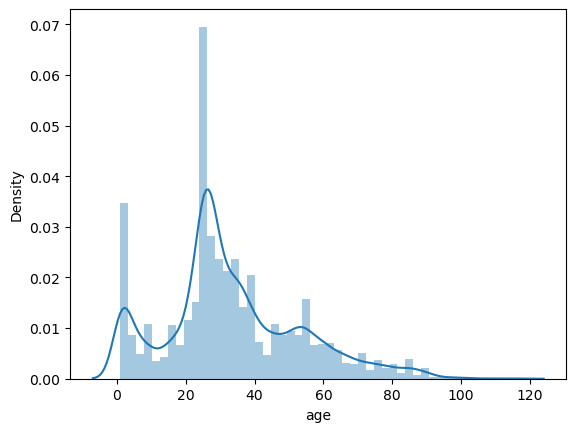

In [6]:
sns.distplot(df['age'])

In [7]:
df['gender'].value_counts()

0    12391
1    11317
Name: gender, dtype: int64

<Axes: xlabel='gender', ylabel='count'>

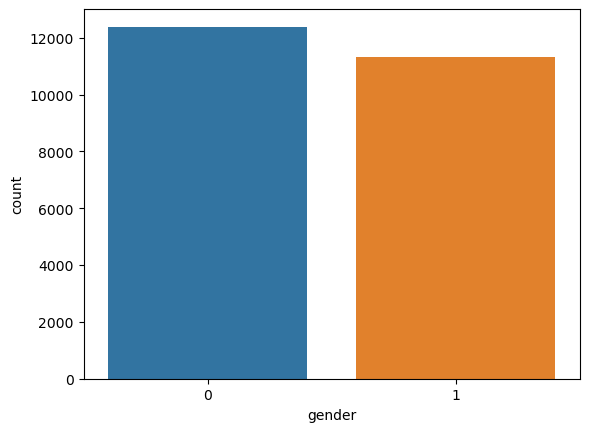

In [8]:
sns.countplot(data=df, x='gender')

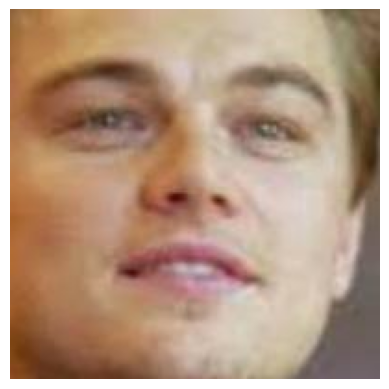

In [9]:
from PIL import Image
img = Image.open(df['image'][3])
plt.axis('off')
plt.imshow(img)

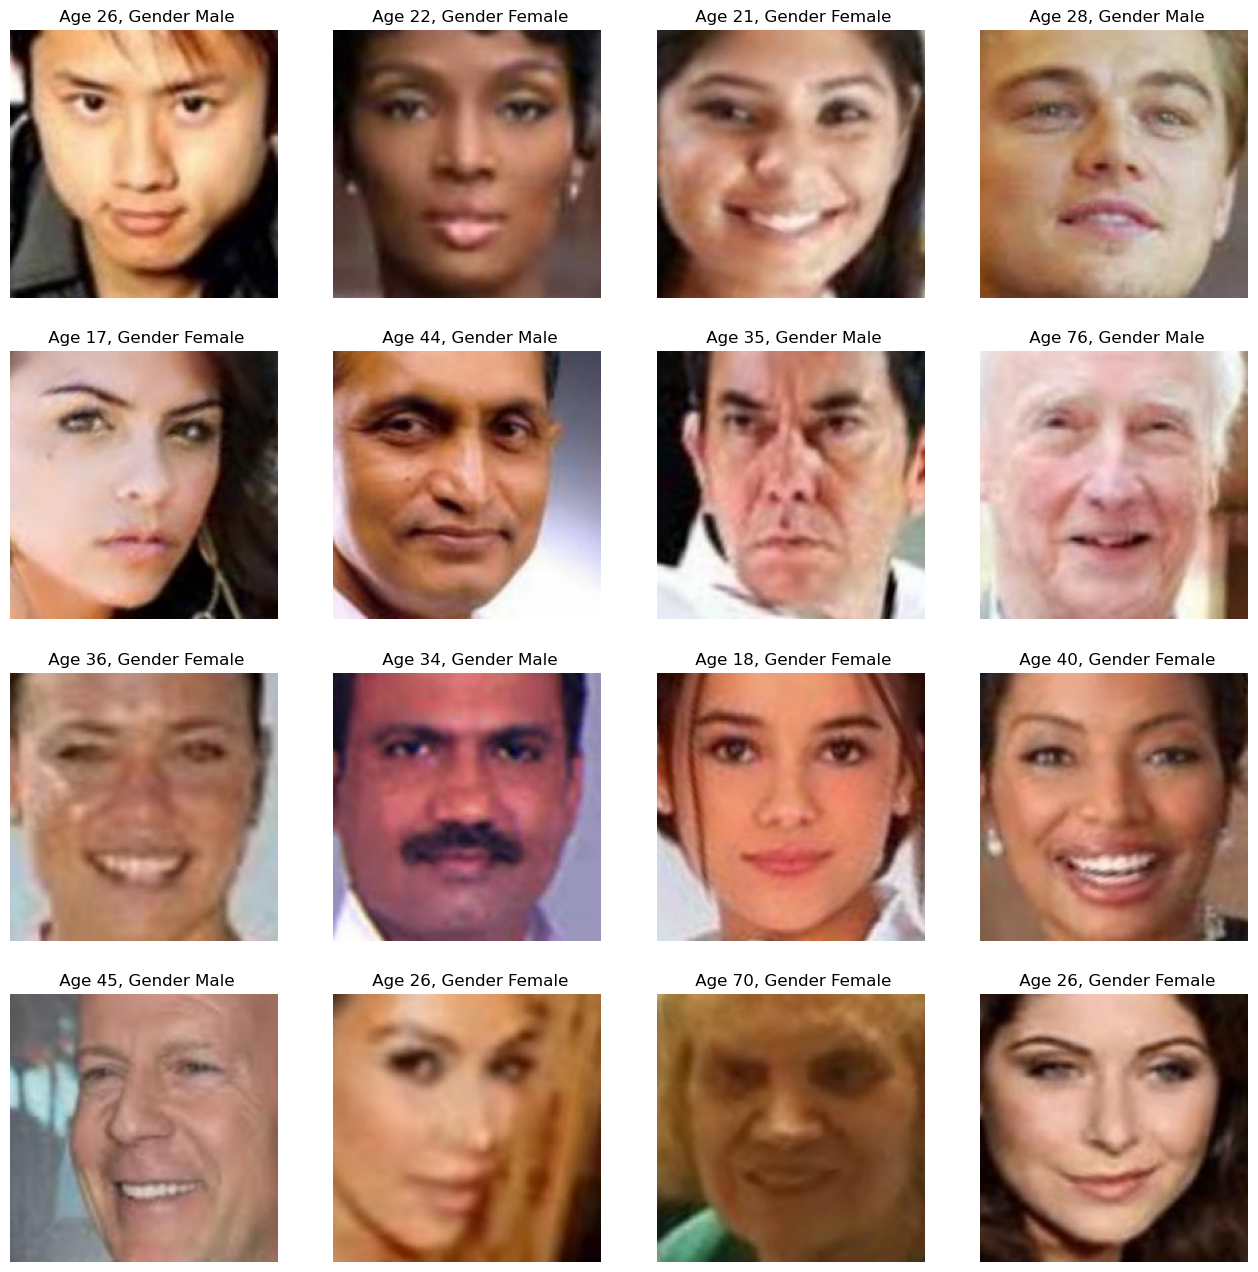

In [10]:
plt.figure(figsize=(16,16))
sample = df.iloc[0:16]
for index, image, gender, age in sample.itertuples():
    plt.subplot(4,4,index+1)
    img = load_img(image)
    img = np.array(img)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f' Age {age}, Gender {gender_dict[gender]}')

# Feature Extraction

In [11]:
def extract_feature(images):
    features=[]
    for image in images:
        img = load_img(image, grayscale=True)
        #Image.ANTIALIAS-->prevent distortion in img while resize 
        img = img.resize((128,128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features),128,128,1)
    return features

In [12]:
X = extract_feature(df['image'])

In [13]:
 X.shape

(23708, 128, 128, 1)

**Normalize**

In [14]:
X = X/255.0

In [15]:
input_shape = (128,128,1)

# Model

In [16]:
inputs = Input((input_shape))
#convolutional layers
conv_1 = Conv2D(32, kernel_size=(3,3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2,2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3,3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2,2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3,3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2,2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3,3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2,2)) (conv_4)

flatten = Flatten() (maxp_4)

#fully connected
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1 , activation='sigmoid', name='gender_out') (dense_1)
output_2 = Dense(1 , activation='relu', name='age_out') (dense_2)

model = Model(inputs=[inputs], outputs=[output_1,output_2])

model.compile(loss=['binary_crossentropy','mae'], optimizer='adam', metrics=['accuracy'])

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 126, 126, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 63, 63, 32)   0           ['conv2d[0][0]']                 
                                                                                              

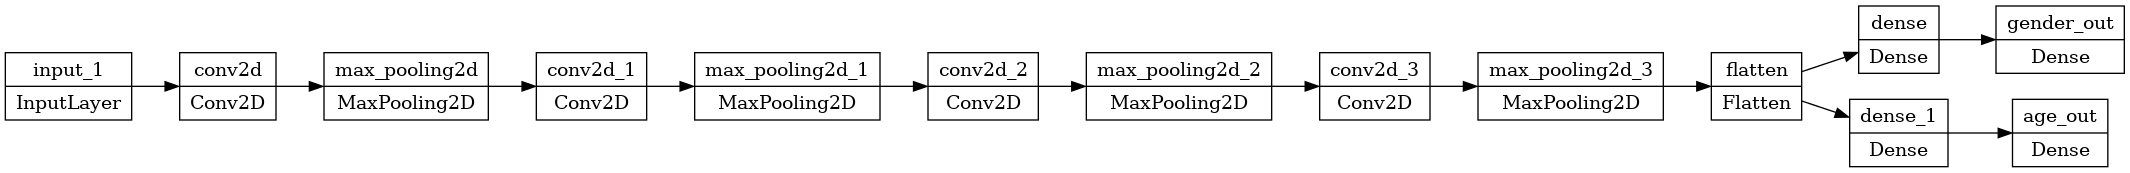

In [18]:
from keras.utils import plot_model
plot_model(model,rankdir='LR')

In [19]:
y_gender, y_age = df['gender'], df['age']

In [20]:
history = model.fit(x=X, y=[y_gender,y_age], batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
593/593 [==============================] - 25s 21ms/step - loss: 17.4104 - gender_out_loss: 0.6912 - age_out_loss: 16.7192 - gender_out_accuracy: 0.5267 - age_out_accuracy: 0.0436 - val_loss: 14.6244 - val_gender_out_loss: 0.6737 - val_age_out_loss: 13.9507 - val_gender_out_accuracy: 0.5761 - val_age_out_accuracy: 0.0462
Epoch 2/30
593/593 [==============================] - 11s 19ms/step - loss: 12.0791 - gender_out_loss: 0.5266 - age_out_loss: 11.5525 - gender_out_accuracy: 0.7393 - age_out_accuracy: 0.0316 - val_loss: 10.3351 - val_gender_out_loss: 0.4911 - val_age_out_loss: 9.8440 - val_gender_out_accuracy: 0.7604 - val_age_out_accuracy: 0.0249
Epoch 3/30
593/593 [==============================] - 11s 19ms/step - loss: 10.0536 - gender_out_loss: 0.4298 - age_out_loss: 9.6239 - gender_out_accuracy: 0.7936 - age_out_accuracy: 0.0181 - val_loss: 9.4061 - val_gender_out_loss: 0.4157 - val_age_out_loss: 8.9904 - val_gender_out_accuracy: 0.8005 - val_age_out_accuracy: 0.0200
Ep

# Evaluation Result

**Gender Graph**

<Figure size 640x480 with 0 Axes>

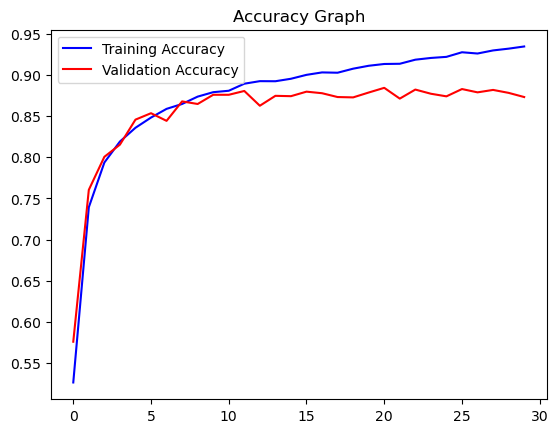

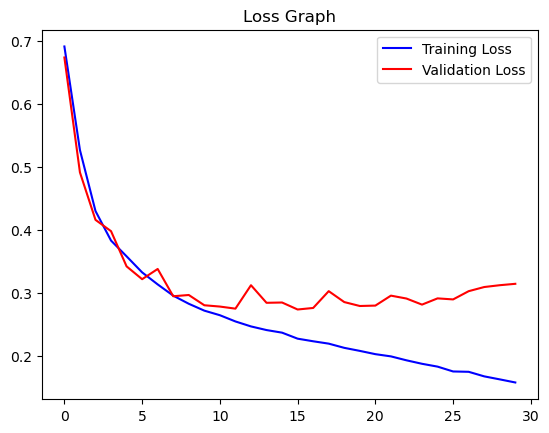

<Figure size 640x480 with 0 Axes>

In [21]:
acc = history.history['gender_out_accuracy']
val_acc =  history.history['val_gender_out_accuracy']
n_epoch = range(len(acc))

plt.plot(n_epoch, acc, 'b', label='Training Accuracy')
plt.plot(n_epoch, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss =  history.history['val_gender_out_loss']
epoch = len(acc)

plt.plot(n_epoch, loss, 'b', label='Training Loss')
plt.plot(n_epoch, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.figure()

**Age Graph**

<Figure size 640x480 with 0 Axes>

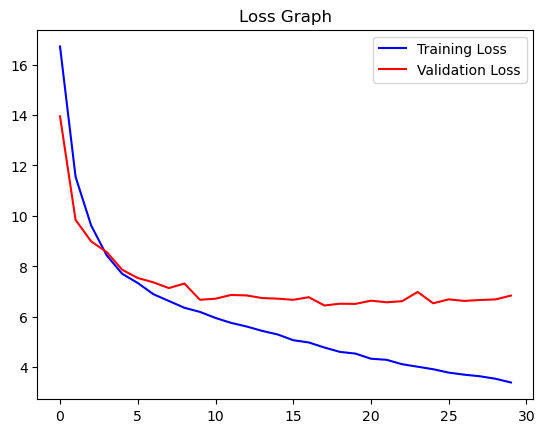

<Figure size 640x480 with 0 Axes>

In [22]:
loss = history.history['age_out_loss']
val_loss =  history.history['val_age_out_loss']
epoch = range(len(acc))

plt.plot(epoch, loss, 'b', label='Training Loss')
plt.plot(epoch, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.figure()

# Prediction With Test Data

In [23]:
X[100].shape

(128, 128, 1)

True Gender:  Female True Age 3
1/1 [==============================] - 0s 268ms/step
Prediceted Gender:  Female Predicted Age 0


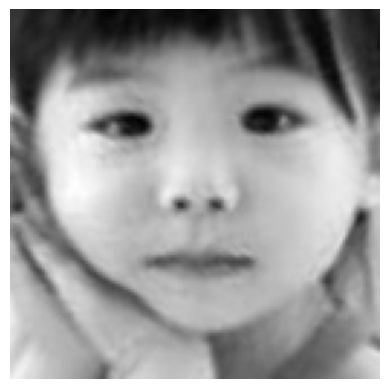

In [24]:
image_index = 100
print("True Gender: ",gender_dict[y_gender[image_index]], "True Age", y_age[image_index])

pred = model.predict(X[image_index].reshape(1,128,128,1))
pred_gender =gender_dict[ round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Prediceted Gender: ",pred_gender, "Predicted Age", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128,128), cmap='gray')

True Gender:  Male True Age 29
1/1 [==============================] - 0s 20ms/step
Prediceted Gender:  Male Predicted Age 27


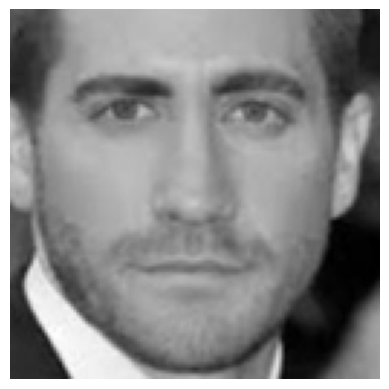

In [25]:
image_index = 150
print("True Gender: ",gender_dict[y_gender[image_index]], "True Age", y_age[image_index])

pred = model.predict(X[image_index].reshape(1,128,128,1))
pred_gender =gender_dict[ round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Prediceted Gender: ",pred_gender, "Predicted Age", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128,128), cmap='gray')

True Gender:  Male True Age 28
1/1 [==============================] - 0s 20ms/step
Prediceted Gender:  Male Predicted Age 28


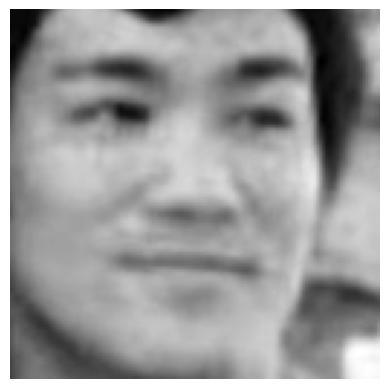

In [26]:
image_index = 3500
print("True Gender: ",gender_dict[y_gender[image_index]], "True Age", y_age[image_index])

pred = model.predict(X[image_index].reshape(1,128,128,1))
pred_gender =gender_dict[ round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Prediceted Gender: ",pred_gender, "Predicted Age", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128,128), cmap='gray')

# Thanks